<a href="https://colab.research.google.com/github/junaidalamgithub/DataScience_NLP/blob/main/Automatic_Ticket_Classification_Topic_Modelling_Md_Junaid_Alam.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Automatic Ticket Classification - Topic Modelling

#### <font color='green'>Author</font>
- Md Junaid Alam

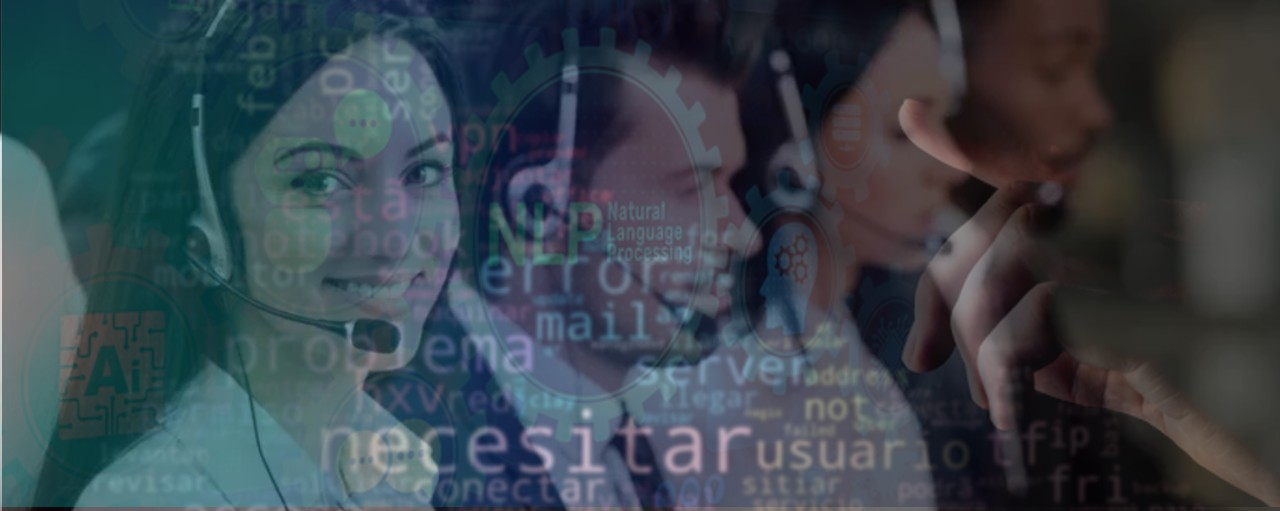

## Problem Statement 

You need to build a model that is able to classify customer complaints based on the products/services. By doing so, you can segregate these tickets into their relevant categories and, therefore, help in the quick resolution of the issue.

You will be doing topic modelling on the <b>.json</b> data provided by the company. Since this data is not labelled, you need to apply NMF to analyse patterns and classify tickets into the following five clusters based on their products/services:

* Credit card / Prepaid card

* Bank account services

* Theft/Dispute reporting

* Mortgages/loans

* Others 


With the help of topic modelling, you will be able to map each ticket onto its respective department/category. You can then use this data to train any supervised model such as logistic regression, decision tree or random forest. Using this trained model, you can classify any new customer complaint support ticket into its relevant department.

## Pipelines that needs to be performed:

You need to perform the following eight major tasks to complete the assignment:

1.  Data loading

2. Text preprocessing

3. Exploratory data analysis (EDA)

4. Feature extraction

5. Topic modelling 

6. Model building using supervised learning

7. Model training and evaluation

8. Model inference

## Importing the necessary libraries

In [ ]:
import json 
import numpy as np
import pandas as pd
import re, nltk, spacy, string
import en_core_web_sm
nlp = en_core_web_sm.load()
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from plotly.offline import plot
import plotly.graph_objects as go
import plotly.express as px

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from pprint import pprint

## Loading the data

The data is in JSON format and we need to convert it to a dataframe.

In [ ]:
# Download the customer complaints json files from my google drive to colab
#! gdown --id 1hHJAoqY7Vb7b0Pt6ovpHg6jn3TGl4wvP

In [ ]:
# Opening JSON file 
f = open("data/complaints.json")# Write the path to your data file and load it 
  
# returns JSON object as  
# a dictionary 
data = json.load(f)
df=pd.json_normalize(data)

## Data preparation

In [ ]:
# Inspect the dataframe to understand the given data.
print(df.head())

                _index      _type      _id  _score   _source.tags  \
0  complaint-public-v2  complaint  3211475     0.0           None   
1  complaint-public-v2  complaint  3229299     0.0  Servicemember   
2  complaint-public-v2  complaint  3199379     0.0           None   
3  complaint-public-v2  complaint  2673060     0.0           None   
4  complaint-public-v2  complaint  3203545     0.0           None   

  _source.zip_code _source.complaint_id                       _source.issue  \
0            90301              3211475   Attempts to collect debt not owed   
1            319XX              3229299     Written notification about debt   
2            77069              3199379  Other features, terms, or problems   
3            48066              2673060      Trouble during payment process   
4            10473              3203545                    Fees or interest   

       _source.date_received _source.state  ... _source.company_response  \
0  2019-04-13T12:00:00-05:00      

In [ ]:
# Check the data type and other info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78313 entries, 0 to 78312
Data columns (total 22 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   _index                             78313 non-null  object 
 1   _type                              78313 non-null  object 
 2   _id                                78313 non-null  object 
 3   _score                             78313 non-null  float64
 4   _source.tags                       10900 non-null  object 
 5   _source.zip_code                   71556 non-null  object 
 6   _source.complaint_id               78313 non-null  object 
 7   _source.issue                      78313 non-null  object 
 8   _source.date_received              78313 non-null  object 
 9   _source.state                      76322 non-null  object 
 10  _source.consumer_disputed          78313 non-null  object 
 11  _source.product                    78313 non-null  obj

In [ ]:
# Check the count of null values in each columns
df.isnull().sum()

_index                                   0
_type                                    0
_id                                      0
_score                                   0
_source.tags                         67413
_source.zip_code                      6757
_source.complaint_id                     0
_source.issue                            0
_source.date_received                    0
_source.state                         1991
_source.consumer_disputed                0
_source.product                          0
_source.company_response                 0
_source.company                          0
_source.submitted_via                    0
_source.date_sent_to_company             0
_source.company_public_response      78309
_source.sub_product                  10571
_source.timely                           0
_source.complaint_what_happened          0
_source.sub_issue                    46297
_source.consumer_consent_provided     1008
dtype: int64

In [ ]:
#print the column names
print(df.columns)

Index(['_index', '_type', '_id', '_score', '_source.tags', '_source.zip_code',
       '_source.complaint_id', '_source.issue', '_source.date_received',
       '_source.state', '_source.consumer_disputed', '_source.product',
       '_source.company_response', '_source.company', '_source.submitted_via',
       '_source.date_sent_to_company', '_source.company_public_response',
       '_source.sub_product', '_source.timely',
       '_source.complaint_what_happened', '_source.sub_issue',
       '_source.consumer_consent_provided'],
      dtype='object')


In [ ]:
#Assign new column names. One way can be to remove the '_', split with '.' and take the meaningful part from the split 
df.columns = [column.split('.')[1] if len(column.split('.'))>1 else column.split('.')[0][1:] for column in df.columns]

In [ ]:
# Check the updated column names
df.columns

Index(['index', 'type', 'id', 'score', 'tags', 'zip_code', 'complaint_id',
       'issue', 'date_received', 'state', 'consumer_disputed', 'product',
       'company_response', 'company', 'submitted_via', 'date_sent_to_company',
       'company_public_response', 'sub_product', 'timely',
       'complaint_what_happened', 'sub_issue', 'consumer_consent_provided'],
      dtype='object')

In [ ]:
# Check the total blanks in the complaints column
len(df[df['complaint_what_happened']==''])

57241

In [ ]:
#Assign nan in place of blanks in the complaints column
df['complaint_what_happened'] = df['complaint_what_happened'].replace(r'^\s*$', np.nan, regex=True)

In [ ]:
# Check the total nan
df['complaint_what_happened'].isna().sum()

57241

In [ ]:
#Remove all rows where complaints column is nan
df = df[df['complaint_what_happened'].notna()]

In [ ]:
# Check the total blanks in the complaints column once again to verify if there are no blank complaints
len(df[df['complaint_what_happened']==''])

0

Hence all the blank complaints are removed

## Prepare the text for topic modeling

Once you have removed all the blank complaints, you need to:

* Make the text lowercase
* Remove text in square brackets
* Remove punctuation
* Remove words containing numbers


Once you have done these cleaning operations you need to perform the following:
* Lemmatize the texts
* Use POS tags to get relevant words from the texts.


In [ ]:
# Write your function here to clean the text and remove all the unnecessary elements.
def clean_dataframe(data, attribute):
    data['Complaint_clean'] = data[attribute].apply(lambda x:x.lower()) # change to lower case
    data['Complaint_clean'] = data[attribute].replace(r'\[[^)]*\]', '', regex=True) # remove the square brackets text
    data['Complaint_clean'] = data[attribute].replace(r'[^\w\s]', '', regex=True) # remove punctuation
    data['Complaint_clean'] = data[attribute].replace(r'\w*\d\w*', '',  regex=True) # remove words containing numbers
    return data.loc[:, [('complaint_what_happened'),('Complaint_clean')]]

In [ ]:
#Write your function to Lemmatize the texts
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

# Let us also import and use swifter to speed up the process
import swifter

wordnet_lemmatizer = WordNetLemmatizer()
def preprocess(document):
    # tokenize into words
    words = word_tokenize(document)
     # remove stop words
    words = [word for word in words if word not in stopwords.words("english")]
    words = [wordnet_lemmatizer.lemmatize(word, pos='v') for word in words]
    # join words to make sentence
    document = " ".join(words)
    return document

def lemmatize_dataframe(data, attribute):
    data[attribute] = data[attribute].swifter.apply(preprocess)
    return data


In [ ]:
#Create a dataframe('df_clean') that will have only the complaints and the lemmatized complaints 
df_clean = lemmatize_dataframe(clean_dataframe(df, 'complaint_what_happened'), 'Complaint_clean')

Pandas Apply:   0%|          | 0/21072 [00:00<?, ?it/s]

In [ ]:
df_clean

,complaint_what_happened,Complaint_clean
1,Good morning my name is XXXX XXXX and I apprec...,Good morning name XXXX XXXX I appreciate could...
2,I upgraded my XXXX XXXX card in XX/XX/2018 and...,I upgrade XXXX XXXX card XX/XX/ tell agent upg...
10,Chase Card was reported on XX/XX/2019. However...,"Chase Card report XX/XX/ . However , fraudulen..."
11,"On XX/XX/2018, while trying to book a XXXX XX...","On XX/XX/ , try book XXXX XXXX ticket , I come..."
14,my grand son give me check for {$1600.00} i de...,grand son give check { $ . } deposit chase acc...
...,...,...
78303,After being a Chase Card customer for well ove...,"After Chase Card customer well decade , offer ..."
78309,"On Wednesday, XX/XX/XXXX I called Chas, my XXX...","On Wednesday , XX/XX/XXXX I call Chas , XXXX X..."
78310,I am not familiar with XXXX pay and did not un...,I familiar XXXX pay understand great risk prov...
78311,I have had flawless credit for 30 yrs. I've ha...,I flawless credit yrs . I 've Chase credit car...


In [ ]:
#Write your function to extract the POS tags 
model = spacy.load("en_core_web_sm")
def preprocess_pos(document):
    tokens = model(document)
    words = [str(word) for word in tokens if word.pos_ in ['NOUN', 'PRON']]
    document = " ".join(words)
    return document

def extract_pos(data, attribute):
    data['complaint_POS_removed'] = data[attribute].swifter.apply(preprocess_pos)
    return data

In [ ]:
df_clean = extract_pos(df_clean, "Complaint_clean")

Pandas Apply:   0%|          | 0/21072 [00:00<?, ?it/s]

In [ ]:
#The clean dataframe should now contain the raw complaint, lemmatized complaint and the complaint after removing POS tags.
df_clean

,complaint_what_happened,Complaint_clean,complaint_POS_removed
1,Good morning my name is XXXX XXXX and I apprec...,Good morning name XXXX XXXX I appreciate could...,morning name XXXX XXXX I cardmember service I ...
2,I upgraded my XXXX XXXX card in XX/XX/2018 and...,I upgrade XXXX XXXX card XX/XX/ tell agent upg...,I XXXX card agent upgrade anniversary date It ...
10,Chase Card was reported on XX/XX/2019. However...,"Chase Card report XX/XX/ . However , fraudulen...",report application submit identity consent ser...
11,"On XX/XX/2018, while trying to book a XXXX XX...","On XX/XX/ , try book XXXX XXXX ticket , I come...",book ticket I offer ticket I card I informatio...
14,my grand son give me check for {$1600.00} i de...,grand son give check { $ . } deposit chase acc...,son check account money son money money time c...
...,...,...,...
78303,After being a Chase Card customer for well ove...,"After Chase Card customer well decade , offer ...",customer decade solicitations credit card bonu...
78309,"On Wednesday, XX/XX/XXXX I called Chas, my XXX...","On Wednesday , XX/XX/XXXX I call Chas , XXXX X...",I provider claim purchase protection benefit I...
78310,I am not familiar with XXXX pay and did not un...,I familiar XXXX pay understand great risk prov...,I pay risk consumers I bank app I years I deal...
78311,I have had flawless credit for 30 yrs. I've ha...,I flawless credit yrs . I 've Chase credit car...,I credit yrs I credit card problems I balance ...


## Exploratory data analysis to get familiar with the data.

Write the code in this task to perform the following:

*   Visualise the data according to the 'Complaint' character length
*   Using a word cloud find the top 40 words by frequency among all the articles after processing the text
*   Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text. ‘




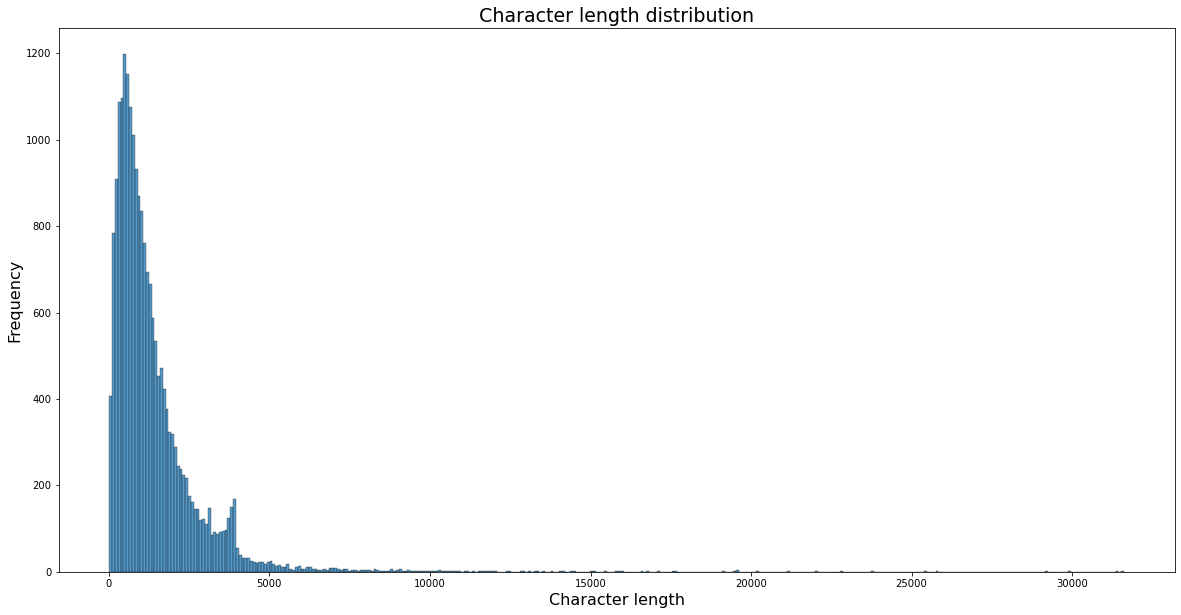

In [ ]:
# Write your code here to visualise the data according to the 'Complaint' character length
import seaborn as sns
char_frequency=df_clean['complaint_what_happened'].apply(lambda x:len(x))
font_size={'fontsize': 16}
title_font_size={'fontsize': 19}

plt.figure(figsize=(20,10))
sns.histplot(char_frequency)
plt.xlabel('Character length', fontdict=font_size)
plt.ylabel('Frequency', fontdict=font_size)
plt.title('Character length distribution', fontdict=title_font_size)
plt.show()

#### Find the top 40 words by frequency among all the articles after processing the text.

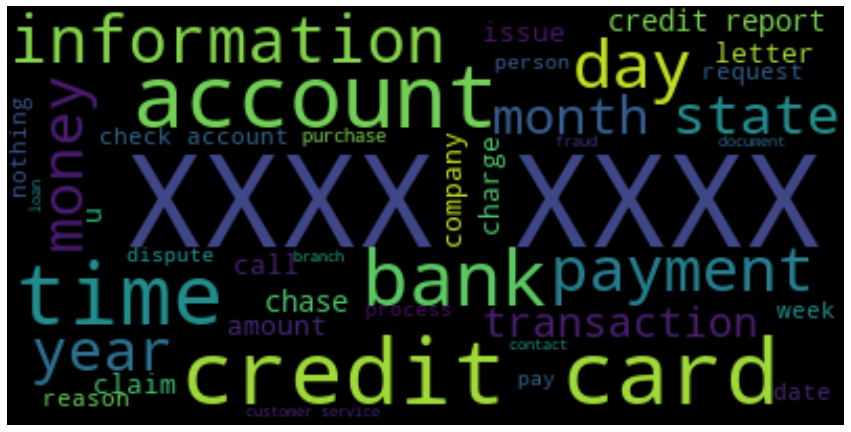

In [ ]:
#Using a word cloud find the top 40 words by frequency among all the articles after processing the text
from wordcloud import WordCloud

text="".join (words for words in df_clean['complaint_POS_removed'])
wordcloud = WordCloud(max_words=40, ).generate(text)

plt.figure(figsize=(15,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [ ]:
#Removing -PRON- from the text corpus
df_clean['Complaint_clean'] = df_clean['complaint_POS_removed'].str.replace('-PRON-', '')

#### Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text.

In [ ]:
# Import ngram and frequency distribution library from nltk
from nltk import ngrams, FreqDist
UNIGRAM =1
BIGRAM = 2
TRIGRAM = 3

In [ ]:
# Let us define a custom function to return ngram using the formula number of tokens-ngram+1
def ngram_for(text, n_gram=1):
    tokens = re.split("\\s", text)
    ngram=[]
    for i in range(len(tokens)-n_gram+1):
        temp= [tokens[j] for j in range(i, i + n_gram)]
        ngram.append(" ".join(temp))
    return ngram

Let us define another function to solve the same purpose as the above function to return the ngram. This function will utilize the inbuilt ngram method of the nltk library. So we can use either of these functions.

In [ ]:
# Let us define another function to return ngram using inbuilt ngram method
def get_ngram(text, n_gram=1):
    grams_list=[]
    for grams in ngrams(text.split(), n_gram):
        grams_list.append(grams)
    return grams_list

In [ ]:
#Write your code here to find the top 30 unigram frequency among the complaints in the cleaned datafram(df_clean). 
ugram = FreqDist(ngram_for(text, UNIGRAM)).most_common(30)
ugram

[('I', 179292),
 ('XXXX', 54931),
 ('account', 42238),
 ('credit', 29726),
 ('card', 26156),
 ('bank', 15844),
 ('time', 15608),
 ('charge', 13600),
 ('payment', 13209),
 ('check', 11435),
 ('money', 11018),
 ('call', 10221),
 ('loan', 9763),
 ('report', 9713),
 ('They', 9447),
 ('information', 9158),
 ('letter', 9000),
 ('state', 8298),
 ('fee', 8284),
 ('amount', 7945),
 ('number', 7925),
 ('phone', 7136),
 ('days', 7129),
 ('company', 6992),
 ('balance', 6956),
 ('payments', 6848),
 ('fund', 6563),
 ('service', 6456),
 ('dispute', 6399),
 ('mortgage', 6346)]

In [ ]:
#Print the top 10 words in the unigram frequency
ugramwords=[]
for i in range(len(ugram)):
    ugramwords.append(ugram[i][0])
top10_words = [x for x in ugramwords if x in set(ugramwords)][:10]
top10_words

['I',
 'XXXX',
 'account',
 'credit',
 'card',
 'bank',
 'time',
 'charge',
 'payment',
 'check']

In [ ]:
#Write your code here to find the top 30 bigram frequency among the complaints in the cleaned datafram(df_clean). 
bigram = FreqDist(ngram_for(text, BIGRAM)).most_common(30)
bigram

[('XXXX XXXX', 27141),
 ('I I', 18772),
 ('credit card', 10627),
 ('account I', 8250),
 ('I account', 5458),
 ('XXXX I', 5445),
 ('I credit', 4746),
 ('card I', 4459),
 ('credit report', 4006),
 ('time I', 3571),
 ('I bank', 3469),
 ('I XXXX', 3247),
 ('check account', 3010),
 ('I card', 2819),
 ('I letter', 2712),
 ('I time', 2699),
 ('I payment', 2678),
 ('customer service', 2525),
 ('I money', 2449),
 ('charge I', 2161),
 ('I charge', 2086),
 ('money I', 1991),
 ('I call', 1935),
 ('payment I', 1879),
 ('bank account', 1775),
 ('days I', 1762),
 ('I customer', 1715),
 ('debit card', 1713),
 ('I check', 1648),
 ('phone call', 1571)]

In [ ]:
#Print the top 10 words in the bigram frequency
bigramwords={}

for i in range(len(bigram)):
    bigramwords[bigram[i][0].split(" ")[0]]= bigram[i][1]
    bigramwords[bigram[i][0].split(" ")[1]]= bigram[i][1]
list(bigramwords.keys())[:10]

['XXXX',
 'I',
 'credit',
 'card',
 'account',
 'report',
 'time',
 'bank',
 'check',
 'letter']

In [ ]:
#Write your code here to find the top 30 trigram frequency among the complaints in the cleaned datafram(df_clean). 
trigram = FreqDist(ngram_for(text, TRIGRAM)).most_common(30)
trigram

[('XXXX XXXX XXXX', 15115),
 ('XXXX XXXX I', 2377),
 ('I credit card', 2140),
 ('I I I', 2125),
 ('credit card I', 1526),
 ('I XXXX XXXX', 1248),
 ('I account I', 1171),
 ('_ _ _', 1073),
 ('I customer service', 978),
 ('credit card account', 861),
 ('account I I', 856),
 ('credit report I', 819),
 ('credit card company', 816),
 ('check account I', 672),
 ('I card I', 606),
 ('account I account', 580),
 ('I I account', 563),
 ('I time I', 548),
 ('I money I', 542),
 ('card I I', 516),
 ('I I credit', 493),
 ('I payment I', 492),
 ('XXXX I I', 468),
 ('I XXXX I', 459),
 ('I credit report', 426),
 ('I charge I', 411),
 ('time I I', 409),
 ('I check account', 402),
 ('I phone call', 389),
 ('I bank account', 387)]

In [ ]:
#Print the top 10 words in the trigram frequency
trigramwords={}

for i in range(len(trigram)):
    trigramwords[trigram[i][0].split(" ")[0]]= trigram[i][1]
    trigramwords[trigram[i][0].split(" ")[1]]= trigram[i][1]
    trigramwords[trigram[i][0].split(" ")[2]]= trigram[i][1]
list(trigramwords.keys())[:10]

['XXXX',
 'I',
 'credit',
 'card',
 'account',
 '_',
 'customer',
 'service',
 'report',
 'company']

## The personal details of customer has been masked in the dataset with xxxx. Let's remove the masked text as this will be of no use for our analysis

In [ ]:
df_clean['Complaint_clean'] = df_clean['Complaint_clean'].str.replace('XXXX','')

In [ ]:
#All masked texts has been removed
df_clean

,complaint_what_happened,Complaint_clean,complaint_POS_removed
1,Good morning my name is XXXX XXXX and I apprec...,morning name I cardmember service I debt ver...,morning name XXXX XXXX I cardmember service I ...
2,I upgraded my XXXX XXXX card in XX/XX/2018 and...,I card agent upgrade anniversary date It agen...,I XXXX card agent upgrade anniversary date It ...
10,Chase Card was reported on XX/XX/2019. However...,report application submit identity consent ser...,report application submit identity consent ser...
11,"On XX/XX/2018, while trying to book a XXXX XX...",book ticket I offer ticket I card I informatio...,book ticket I offer ticket I card I informatio...
14,my grand son give me check for {$1600.00} i de...,son check account money son money money time c...,son check account money son money money time c...
...,...,...,...
78303,After being a Chase Card customer for well ove...,customer decade solicitations credit card bonu...,customer decade solicitations credit card bonu...
78309,"On Wednesday, XX/XX/XXXX I called Chas, my XXX...",I provider claim purchase protection benefit I...,I provider claim purchase protection benefit I...
78310,I am not familiar with XXXX pay and did not un...,I pay risk consumers I bank app I years I deal...,I pay risk consumers I bank app I years I deal...
78311,I have had flawless credit for 30 yrs. I've ha...,I credit yrs I credit card problems I balance ...,I credit yrs I credit card problems I balance ...


## Feature Extraction
Convert the raw texts to a matrix of TF-IDF features

**max_df** is used for removing terms that appear too frequently, also known as "corpus-specific stop words"
max_df = 0.95 means "ignore terms that appear in more than 95% of the complaints"

**min_df** is used for removing terms that appear too infrequently
min_df = 2 means "ignore terms that appear in less than 2 complaints"

In [ ]:
#Write your code here to initialise the TfidfVectorizer 
tfidf = TfidfVectorizer(max_df = 0.95, min_df = 2, stop_words='english')

#### Create a document term matrix using fit_transform

The contents of a document term matrix are tuples of (complaint_id,token_id) tf-idf score:
The tuples that are not there have a tf-idf score of 0

In [ ]:
#Write your code here to create the Document Term Matrix by transforming the complaints column present in df_clean.
dtm = tfidf.fit_transform(df_clean['Complaint_clean']).toarray()
print(dtm)  # returns the row number and column number of cells which have 1 as value

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


## Topic Modelling using NMF

Non-Negative Matrix Factorization (NMF) is an unsupervised technique so there are no labeling of topics that the model will be trained on. The way it works is that, NMF decomposes (or factorizes) high-dimensional vectors into a lower-dimensional representation. These lower-dimensional vectors are non-negative which also means their coefficients are non-negative.

In this task you have to perform the following:

* Find the best number of clusters 
* Apply the best number to create word clusters
* Inspect & validate the correction of each cluster wrt the complaints 
* Correct the labels if needed 
* Map the clusters to topics/cluster names

In [ ]:
from sklearn.decomposition import NMF

## Manual Topic Modeling
You need to do take the trial & error approach to find the best num of topics for your NMF model.

The only parameter that is required is the number of components i.e. the number of topics we want. This is the most crucial step in the whole topic modeling process and will greatly affect how good your final topics are.

In [ ]:
#Load your nmf_model with the n_components i.e 5
num_topics = 5 #write the value you want to test out

#keep the random_state =40
nmf_model = NMF(n_components=num_topics, random_state =40, max_iter=dtm.shape[0] ) #write your code here

In [ ]:
nmf_model.fit(dtm)
len(tfidf.get_feature_names())

7132

In [ ]:
#Print the Top15 words for each of the topics

W = nmf_model.fit_transform(dtm)  # Document-topic matrix
H = nmf_model.components_       # Topic-term matrix
words = np.array(tfidf.get_feature_names())
topic_words = pd.DataFrame(np.zeros((num_topics, 15)), index=[f'Topic {i + 1}' for i in range(num_topics)],
                           columns=[f'Word {i + 1}' for i in range(15)]).astype(str)
for i in range(num_topics):
    ix = H[i].argsort()[::-1][:15]
    topic_words.iloc[i] = words[ix]

topic_words

,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14,Word 15
Topic 1,account,check,bank,money,fund,deposit,branch,number,transfer,business,days,claim,chase,time,transaction
Topic 2,credit,report,inquiry,inquiries,account,score,debt,card,information,bureaus,company,remove,identity,letter,limit
Topic 3,loan,mortgage,modification,home,property,letter,time,document,payments,rate,years,foreclosure,request,refinance,information
Topic 4,card,charge,credit,dispute,purchase,fee,fraud,time,company,service,merchant,refund,balance,transaction,use
Topic 5,payment,payments,fee,balance,month,pay,statement,time,date,auto,mortgage,days,statements,months,day


In [ ]:
#Create the best topic for each complaint in terms of integer value 0,1,2,3 & 4
results = nmf_model.transform(dtm)
best_topics = results.argmax(axis=1)

In [ ]:
#Assign the best topic to each of the cmplaints in Topic Column

df_clean['Topic'] = best_topics #write your code to assign topics to each rows.

In [ ]:
df_clean.head()

,complaint_what_happened,Complaint_clean,complaint_POS_removed,Topic
1,Good morning my name is XXXX XXXX and I apprec...,morning name I cardmember service I debt ver...,morning name XXXX XXXX I cardmember service I ...,0
2,I upgraded my XXXX XXXX card in XX/XX/2018 and...,I card agent upgrade anniversary date It agen...,I XXXX card agent upgrade anniversary date It ...,3
10,Chase Card was reported on XX/XX/2019. However...,report application submit identity consent ser...,report application submit identity consent ser...,1
11,"On XX/XX/2018, while trying to book a XXXX XX...",book ticket I offer ticket I card I informatio...,book ticket I offer ticket I card I informatio...,1
14,my grand son give me check for {$1600.00} i de...,son check account money son money money time c...,son check account money son money money time c...,0


In [ ]:
#Print the first 5 Complaint for each of the Topics
df_clean.groupby('Topic').head(5).sort_values('Topic')

,complaint_what_happened,Complaint_clean,complaint_POS_removed,Topic
1,Good morning my name is XXXX XXXX and I apprec...,morning name I cardmember service I debt ver...,morning name XXXX XXXX I cardmember service I ...,0
21,"On XXXX XX/XX/2019, I made a {$300.00} payment...",I payment retailer pay website I scam website ...,I payment retailer pay website I scam website ...,0
17,With out notice J.P. Morgan Chase restricted m...,notice account debit card I branch customer se...,notice account debit card I branch customer se...,0
14,my grand son give me check for {$1600.00} i de...,son check account money son money money time c...,son check account money son money money time c...,0
27,I opened an account with chase bank on XXXX an...,I code bonus I term everything account I depos...,I code bonus I term everything account I depos...,0
15,Can you please remove inquiry,inquiry,inquiry,1
10,Chase Card was reported on XX/XX/2019. However...,report application submit identity consent ser...,report application submit identity consent ser...,1
23,I have a Chase credit card which is incorrectl...,I credit card data credit report company issue,I credit card data credit report company issue,1
26,I have reached out to XXXX several times in at...,I time inquiry remove I I call contact credito...,I time inquiry remove I I call contact credito...,1
11,"On XX/XX/2018, while trying to book a XXXX XX...",book ticket I offer ticket I card I informatio...,book ticket I offer ticket I card I informatio...,1


#### After evaluating the mapping, if the topics assigned are correct then assign these names to the relevant topic:
* Bank Account services
* Credit card or prepaid card
* Theft/Dispute Reporting
* Mortgage/Loan
* Others

In [ ]:
#Create the dictionary of Topic names and Topics

Topic_names = { 0: "Bank Account services",
1: "Credit card or prepaid card",
2: "Mortgage/Loan",
3: "Theft/Dispute Reporting",
4: "Others"  }
#Replace Topics with Topic Names
df_clean['Topic'] = df_clean['Topic'].map(Topic_names)

In [ ]:
df_clean

,complaint_what_happened,Complaint_clean,complaint_POS_removed,Topic
1,Good morning my name is XXXX XXXX and I apprec...,morning name I cardmember service I debt ver...,morning name XXXX XXXX I cardmember service I ...,Bank Account services
2,I upgraded my XXXX XXXX card in XX/XX/2018 and...,I card agent upgrade anniversary date It agen...,I XXXX card agent upgrade anniversary date It ...,Theft/Dispute Reporting
10,Chase Card was reported on XX/XX/2019. However...,report application submit identity consent ser...,report application submit identity consent ser...,Credit card or prepaid card
11,"On XX/XX/2018, while trying to book a XXXX XX...",book ticket I offer ticket I card I informatio...,book ticket I offer ticket I card I informatio...,Credit card or prepaid card
14,my grand son give me check for {$1600.00} i de...,son check account money son money money time c...,son check account money son money money time c...,Bank Account services
...,...,...,...,...
78303,After being a Chase Card customer for well ove...,customer decade solicitations credit card bonu...,customer decade solicitations credit card bonu...,Theft/Dispute Reporting
78309,"On Wednesday, XX/XX/XXXX I called Chas, my XXX...",I provider claim purchase protection benefit I...,I provider claim purchase protection benefit I...,Theft/Dispute Reporting
78310,I am not familiar with XXXX pay and did not un...,I pay risk consumers I bank app I years I deal...,I pay risk consumers I bank app I years I deal...,Bank Account services
78311,I have had flawless credit for 30 yrs. I've ha...,I credit yrs I credit card problems I balance ...,I credit yrs I credit card problems I balance ...,Others


## Supervised model to predict any new complaints to the relevant Topics.

You have now build the model to create the topics for each complaints.Now in the below section you will use them to classify any new complaints.

Since you will be using supervised learning technique we have to convert the topic names to numbers(numpy arrays only understand numbers)

In [ ]:
#Create the dictionary again of Topic names and Topics

Topic_names =  {"Bank Account services": 0,
"Credit card or prepaid card": 1,
"Mortgage/Loan": 2,
"Theft/Dispute Reporting": 3,
"Others": 4  }
#Replace Topics with Topic Names
df_clean['Topic'] = df_clean['Topic'].map(Topic_names)

In [ ]:
df_clean

,complaint_what_happened,Complaint_clean,complaint_POS_removed,Topic
1,Good morning my name is XXXX XXXX and I apprec...,morning name I cardmember service I debt ver...,morning name XXXX XXXX I cardmember service I ...,0
2,I upgraded my XXXX XXXX card in XX/XX/2018 and...,I card agent upgrade anniversary date It agen...,I XXXX card agent upgrade anniversary date It ...,3
10,Chase Card was reported on XX/XX/2019. However...,report application submit identity consent ser...,report application submit identity consent ser...,1
11,"On XX/XX/2018, while trying to book a XXXX XX...",book ticket I offer ticket I card I informatio...,book ticket I offer ticket I card I informatio...,1
14,my grand son give me check for {$1600.00} i de...,son check account money son money money time c...,son check account money son money money time c...,0
...,...,...,...,...
78303,After being a Chase Card customer for well ove...,customer decade solicitations credit card bonu...,customer decade solicitations credit card bonu...,3
78309,"On Wednesday, XX/XX/XXXX I called Chas, my XXX...",I provider claim purchase protection benefit I...,I provider claim purchase protection benefit I...,3
78310,I am not familiar with XXXX pay and did not un...,I pay risk consumers I bank app I years I deal...,I pay risk consumers I bank app I years I deal...,0
78311,I have had flawless credit for 30 yrs. I've ha...,I credit yrs I credit card problems I balance ...,I credit yrs I credit card problems I balance ...,4


In [ ]:
#Keep the columns"complaint_what_happened" & "Topic" only in the new dataframe --> training_data
training_data = df_clean[['complaint_what_happened', 'Topic']].copy()

In [ ]:
training_data

,complaint_what_happened,Topic
1,Good morning my name is XXXX XXXX and I apprec...,0
2,I upgraded my XXXX XXXX card in XX/XX/2018 and...,3
10,Chase Card was reported on XX/XX/2019. However...,1
11,"On XX/XX/2018, while trying to book a XXXX XX...",1
14,my grand son give me check for {$1600.00} i de...,0
...,...,...
78303,After being a Chase Card customer for well ove...,3
78309,"On Wednesday, XX/XX/XXXX I called Chas, my XXX...",3
78310,I am not familiar with XXXX pay and did not un...,0
78311,I have had flawless credit for 30 yrs. I've ha...,4


#### Apply the supervised models on the training data created. In this process, you have to do the following:
* Create the vector counts using Count Vectoriser
* Transform the word vecotr to tf-idf
* Create the train & test data using the train_test_split on the tf-idf & topics


In [ ]:
#Write your code to get the Vector count
vectorizer = CountVectorizer(ngram_range=(1,3), max_df=0.95, min_df=20,  stop_words='english')
vectorized_words = vectorizer.fit_transform(training_data['complaint_what_happened']).toarray()

#Write your code here to transform the word vector to tf-idf
transformer= TfidfTransformer()
tfidf_matrix = transformer.fit_transform(vectorized_words).toarray()

In [ ]:
tfidf_matrix

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.10995703, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.0643377 , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [ ]:
# Create features and target
tf_idf = TfidfVectorizer(max_df = 0.95, min_df = 2, stop_words='english')
dtm = tf_idf.fit_transform(training_data['complaint_what_happened'])
X = pd.DataFrame(dtm.toarray(), columns= tf_idf.get_feature_names() )
y = training_data['Topic']

You have to try atleast 3 models on the train & test data from these options:
* Logistic regression
* Decision Tree
* Random Forest
* Naive Bayes (optional)

**Using the required evaluation metrics judge the tried models and select the ones performing the best**

In [ ]:
# Write your code here to build any 3 models and evaluate them using the required metrics
# Import the required libraries for train test split and metrics
from sklearn.model_selection import train_test_split
from sklearn import metrics

In [ ]:
# split the dateset into train and test datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, train_size=0.7, random_state=42)
print("Dimension of X_train:", X_train.shape)
print("Dimension of X_test:", X_test.shape)

Dimension of X_train: (14750, 15947)
Dimension of X_test: (6322, 15947)


### Using Logistic Regression

In [ ]:
# Logistic regression
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

In [ ]:
# making the predictions
y_train_pred = logreg.predict(X_train)
y_pred = logreg.predict(X_test)

In [ ]:
# Determine the Accuracy of the Predicted model.
print("The train accuracy of the logistic regression model is: ", metrics.accuracy_score(y_train,y_train_pred))
print("The test accuracy of the logistic regression model is: ", metrics.accuracy_score(y_test,y_pred))

The train accuracy of the logistic regression model is:  0.9579661016949153
The test accuracy of the logistic regression model is:  0.9093641252768111


### Using Decision Tree

In [ ]:
from sklearn.tree import DecisionTreeClassifier
dtree = DecisionTreeClassifier(criterion='entropy', random_state=100)
# Fit the tree model on training data
dtree.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', random_state=100)

In [ ]:
#Predict the response for the test dataset
y_pred = dtree.predict(X_test)

In [ ]:
# Determine the Accuracy of the Predicted model.
print("The test accuracy of the model is: ", metrics.accuracy_score(y_test,y_pred))

The test accuracy of the model is:  0.780607402720658


### Using Random Forest

In [ ]:
# Importing random forest classifier from sklearn library
from sklearn.ensemble import RandomForestClassifier

In [ ]:
# Define a function to execute RandomForest classifier with number of trees as parameters with default as 11
def executeRandomForest(n_trees=11):
    rfc = RandomForestClassifier(n_estimators=n_trees)
    rfc.fit(X_train , y_train)
    y_train_pred = logreg.predict(X_train)
    y_pred = rfc.predict(X_test)
    #print(metrics.classification_report(y_test, y_pred))
    # Determine the Accuracy of the Predicted model.
    print("The train accuracy of the model is: ", metrics.accuracy_score(y_train,y_train_pred))
    print("The test accuracy of the model is: ", metrics.accuracy_score(y_test,y_pred))

In [ ]:
# Running the random forest with 11 trees
executeRandomForest()

The train accuracy of the model is:  0.9579661016949153
The test accuracy of the model is:  0.7712749130022145


In [ ]:
# Running the random forest with 100 trees
executeRandomForest(100)

The train accuracy of the model is:  0.9579661016949153
The test accuracy of the model is:  0.8335969629863967


### Using Naive Bayes Classifier

In [ ]:
# Import and create a Multinomial Naive Bayes Classifier
from sklearn.naive_bayes import MultinomialNB
nb = MultinomialNB()
nb.fit(X_train, y_train)
y_pred = nb.predict(X_test)
y_train_pred = nb.predict(X_train)

In [ ]:
# Determine the Accuracy of the Predicted model.
print("The train accuracy of the model is: ", metrics.accuracy_score(y_train,y_train_pred))
print("The test accuracy of the model is: ", metrics.accuracy_score(y_test,y_pred))

The train accuracy of the model is:  0.7705084745762711
The test accuracy of the model is:  0.726036064536539


### Inference

Hence after experimenting with different models we observe that the **LogisticRegression** model gives a comparatively better accuracy with:
- **Training Accuracy** : <font color='green'>96%</font>
- **Testing Accuracy**  : <font color='green'>91%</font>

Hence in this case we can select the LogisticRegression model.

<font color='blue'>N.B: - Please note that while these experiments were done with different models with either deafult values of parameters or very few hyperparameter tuning, but there is a scope of tuning the hyperparameters, use cross validation using GirdSearchCV or other methodologies to improve the models even further.</font>

### Let us now test our model with some sample text to valiadate if it is mapping the text to correct topic

In [ ]:
# Let us redefine the topic mappings

Topic_mappings = { 0: "Bank Account services",
1: "Credit card or prepaid card",
2: "Mortgage/Loan",
3: "Theft/Dispute Reporting",
4: "Others"  }

In [ ]:
# Let us take a sample complaint

sample_complaint= ["Dear sir, I am having a savings account with your bank's xxxxxx branch (Name of the Branch).\
I request you to change the communication address as well as mobile number and E-mail Id for the same. \
The Account details are: XYZ (Name of Account holder) \
Account no. 12345xxxxxx New Address: XYZ( Name) Address line 1 \
( Flat no./ House no., Lane/Street/Road), Address Line 2 (Name of Colony, Area/ Landmark)\
City Name (State/Province) Country, Pin code /Zip code \
New Mobile Number: 91-xxx-xxx-xxxx New Mail Id: xxxxxxxxx@rediffmail/gmail/hotmail.com"]

In [ ]:
# Vectorize the complaint text to feed in to the logistic regression model that we trained.
vectorized_complaint = tf_idf.transform(sample_complaint)

In [ ]:
# Let us check that the complaint text comment is calssified to which topic.
print('The given complaint belongs to the topic : ',Topic_mappings.get(logreg.predict(vectorized_complaint)[0]))

The given complaint belongs to the topic :  Bank Account services


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning:

X does not have valid feature names, but LogisticRegression was fitted with feature names



##### <font color='green'>Hence we observe that the model correctly classifies the topic to Bank Account Services</font>

<center><font color='#ccc'>============================================ End of Analysis ============================================</font></center>